# `pandera`: Statistical Data Validation of Pandas Dataframes

### Niels Bantilan

Scipy 2020

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint

from IPython.display import display, Image, Markdown
from IPython.core.display import HTML

sns.set_style(
    "white",
    {
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

warnings.simplefilter("ignore")

## What's a `DataFrame`?

In [2]:
import uuid

dataframe = pd.DataFrame({
    "person_id": [str(uuid.uuid4())[:7] for _ in range(6)],
    "hours_worked": [38.5, 41.25, "35.0", 27.75, 22.25, -20.5],
    "wage_per_hour": [15.1, 15, 21.30, 17.5, 19.50, 25.50],
}).set_index("person_id")

df = dataframe

In [3]:
dataframe.head()

,hours_worked,wage_per_hour
person_id,,
aafee0b,38.5,15.1
0a917a3,41.25,15.0
2d1786b,35.0,21.3
263cf89,27.75,17.5
89a09dc,22.25,19.5


## What's Data Validation?

Data validation is the act of _falsifying_ data against explicit assumptions
for some downstream purpose, like analysis, modeling, and visualization.

> "All swans are white"

In [4]:
%%html
<p>
    <a href="https://commons.wikimedia.org/wiki/File:Black_Swans.jpg#/media/File:Black_Swans.jpg">
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Black_Swans.jpg" alt="Pair of black swans swimming" height="480" width="300"
     style="display: block; margin-left: auto; margin-right: auto;"/>
    </a>
    <p style="font-size: x-small; text-align: center;">
    <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>,
    <a href="https://commons.wikimedia.org/w/index.php?curid=1243220">Link</a>
    </p>
</p>

## Why Do I Need it?

- It can be difficult to reason about and debug data processing pipelines.

- It's critical to ensuring data quality in many contexts especially when
  the end product informs business decisions, supports scientific
  findings, or generates predictions in a production setting.

## Everyone has a personal relationship with their dataframes

In [5]:
def process_data(df):
    return (
        df.assign(
            weekly_income=lambda x: x.hours_worked * x.wage_per_hour
        )
    )

try:
    process_data(dataframe)
except TypeError as exc:
    print(exc)

can't multiply sequence by non-int of type 'float'


### One day, you encounter an error log trail and decide to follow it...

```python
/usr/local/miniconda3/envs/pandera-presentations/lib/python3.7/site-packages/pandas/core/ops/__init__.py in masked_arith_op(x, y, op)
    445         if mask.any():
    446             with np.errstate(all="ignore"):
--> 447                 result[mask] = op(xrav[mask], com.values_from_object(yrav[mask]))
    448 
    449     else:

TypeError: can't multiply sequence by non-int of type 'float'
```

### And you find yourself at the top of a function...

In [6]:
def process_data(df):
    ...

### You look around, and see some hints of what had happened...

In [7]:
def process_data(df):
    return (
        df.assign(
            weekly_income=lambda x: x.hours_worked * x.wage_per_hour
        )
    )

### You sort of know what's going on, but you want to take a closer look!

In [8]:
def process_data(df):
    import pdb; pdb.set_trace()  # <- insert breakpoint
    return (
        df.assign(
            weekly_income=lambda x: x.hours_worked * x.wage_per_hour
        )
    )

### And you find some funny business going on...

In [9]:
>>> print(df)

          hours_worked  wage_per_hour
person_id                            
aafee0b           38.5           15.1
0a917a3          41.25           15.0
2d1786b           35.0           21.3
263cf89          27.75           17.5
89a09dc          22.25           19.5
e256747          -20.5           25.5


In [10]:
>>> df.dtypes

hours_worked      object
wage_per_hour    float64
dtype: object

In [11]:
>>> df.hours_worked.map(type)

person_id
aafee0b    <class 'float'>
0a917a3    <class 'float'>
2d1786b      <class 'str'>
263cf89    <class 'float'>
89a09dc    <class 'float'>
e256747    <class 'float'>
Name: hours_worked, dtype: object

### You squash the bug and add documentation for the next weary traveler who happens upon this code.

In [12]:
def process_data(df):
    return (
        df
        .astype({"hours_worked": float, "wage_per_hour": float})  # <- make sure columns are floats
        .assign(
            hours_worked=lambda x: x.hours_worked.where(  # <- replace negative values with nans
                x.hours_worked >= 0, np.nan
            )
        )
        .assign(
            weekly_income=lambda x: x.hours_worked * x.wage_per_hour
        )
    )

In [13]:
>>> process_data(df)

,hours_worked,wage_per_hour,weekly_income
person_id,,,
aafee0b,38.50,15.1,581.350
0a917a3,41.25,15.0,618.750
2d1786b,35.00,21.3,745.500
263cf89,27.75,17.5,485.625
89a09dc,22.25,19.5,433.875
e256747,NaN,25.5,NaN


### A few months later...

### You find yourself at a familiar function, but it looks a little different from when you left it...

In [14]:
# This needs to be here, but skipped for story-telling effect in the slides
import pandera as pa
from pandera import Column, Check

in_schema = pa.DataFrameSchema({
    "hours_worked": Column(pa.Float, coerce=True, nullable=True),
    "wage_per_hour": Column(pa.Float, coerce=True, nullable=True),
})

out_schema = (
    in_schema
    .update_column("hours_worked", checks=Check.greater_than_or_equal_to(0))
    .add_columns({"weekly_income": Column(pa.Float, nullable=True)})
)

In [15]:
@pa.check_input(in_schema)
@pa.check_output(out_schema)
def process_data(df):
    return (
        df.assign(
            hours_worked=lambda x: x.hours_worked.where(  # <- replace negative values with nans
                x.hours_worked >= 0, np.nan
            )
        )
        .assign(
            weekly_income=lambda x: x.hours_worked * x.wage_per_hour
        )
    )

### You look above and see what `in_schema` and `out_schema` are, finding a `NOTE` that a fellow traveler has left for you.

In [16]:
import pandera as pa
from pandera import DataFrameSchema, Column, Check

# NOTE: this is what's supposed to be in `df` going into `process_data`
in_schema = DataFrameSchema({
    "hours_worked": Column(pa.Float, coerce=True, nullable=True),
    "wage_per_hour": Column(pa.Float, coerce=True, nullable=True),
})

# ... and this is what `process_data` is supposed to return.
out_schema = (
    in_schema
    .update_column("hours_worked", checks=Check.greater_than_or_equal_to(0))
    .add_columns({"weekly_income": Column(pa.Float, nullable=True)})
)

@pa.check_input(in_schema)
@pa.check_output(out_schema)
def process_data(df):
    ...

## Moral of the Story

The better you can reason about the contents of a dataframe,
the faster you can debug.

The faster you can debug, the sooner you can focus on
downstream tasks that you care about.

# Outline

- Data validation in theory and practice.
- Brief introduction to `pandera`
- Case Study: **Fatal Encounters** dataset
- Roadmap

# Data Validation in Theory and Practice

According to the European Statistical System:

> Data validation is an activity in which it is verified whether or not a combination of values is a member of a set of acceptable value combinations.
> [[Di Zio et al. 2015](https://ec.europa.eu/eurostat/cros/system/files/methodology_for_data_validation_v1.0_rev-2016-06_final.pdf)]

# Data Validation in Theory and Practice

More formally, we can relate this definition to one of the core principles
of the scientific method: **falsifiability**

$v(x) \twoheadrightarrow \{ {True}, {False} \}$

Where $x$ is a set of data values and $v$ is a surjective validation
function, meaning that there exists at least one $x$ that maps onto each
of the elements in the set $\{True, False\}$ [[van der Loo et al. 2019](https://arxiv.org/pdf/1912.09759.pdf)].


### Case 1: Unfalsifiable

$v(x) \rightarrow True$

> **Example:** "my dataframe can have any number of columns of any type"
> ```python
> lambda df: True
> ```

### Case 2: Unverifiable

$v(x) \rightarrow False$

> **Example:** "my dataframe has an infinite number of rows and columns"
> ```python
> lambda df: False
> ```

## Types of Validation Rules

[[van der Loo et al. 2019](https://arxiv.org/pdf/1912.09759.pdf)]

### Technical Checks

Have to do with the properties of the data structure:

- `income` is a numeric variable, `occupation` is a categorical variable.
- `email_address` should be unique.
- null (missing) values are permitted in the `occupation` field.

### Domain-specific Checks

Have to do with properties specific to the topic under study:

- the `age` variable should be between the range 0 and 120
- the `income` for records where `age` is below the legal
  working age should be `nan`
- certain categories of `occupation` tend to have higher `income` than others

## Types of Validation Rules

### Deterministic Checks

Checks that express hard-coded logical rules

> the mean `age` should be between `30` and `40` years old.
> ```python
> lambda age: 30 <= age.mean() <= 40
> ```

### Probabilistic Checks

Checks that explicitly incorporate randomness and distributional variability

> the 95% confidence interval or mean `age` should be between `30` and `40` years old.
> ```python
> def prob_check_age(age):
>     mu = age.mean()
>     ci = 1.96 * (age.std() / np.sqrt(len(age))
>     return 30 <= mu - ci and mu + ci <= 40
> ```

## Statistical Type Safety

Verifying the assumptions about the distributional properties of a dataset
to ensure that statistical operations on those data are valid.

- "the training samples are independently and identically distributed"

- "features `x1`, `x2`, and `x3` are not correlated"

- "the variance of feature `x` is greater than some threshold `t`"

- "the label distribution is consistent across the training and test set"

## Data Validation Workflow in Practice

In [22]:
%%html
<img src="../figures/pandera_process.png", width=275
 style="display: block; margin-left: auto; margin-right: auto;"/>

# User Story

> As a machine learning engineer who uses `pandas` every day,
I want a data validation tool that's intuitive, flexible,
customizable, and easy to integrate into my ETL pipelines
so that I can spend less time worrying about the correctness
of a dataframe's contents and more time training models.

<img src="https://raw.githubusercontent.com/pandera-dev/pandera/master/docs/source/_static/pandera-logo.png" width=150>

# Introducing `pandera`

A design-by-contract data validation library that exposes an intuitive
API for expressing dataframe schemas.

### Refactoring the Validation Function

$v(x) \twoheadrightarrow \{ {True}, {False} \}$

$s(v, x) \rightarrow \begin{cases} \mbox{x,} & \mbox{if } v(x) = true \\ \mbox{error,} & \mbox{otherwise} \end{cases}$

Where $s$ is a *schema* function that takes two arguments: the validation function $v$
and some data $x$.

### Why?

**Compositionality**

Consider a data processing function $f(x) \rightarrow x'$ that cleans the raw dataset $x$.

We can use the schema to define any number of composite functions:

- $f(s(x))$ first validates the raw data to catch invalid data before it's preprocessed.

- $s(f(x))$ validates the output of $f$ to check that the processing function is fulfilling the contract defined in $s$

- $s(f(s'(x))$: the data validation <span style="font-size: 30px; padding: 10px;">🥪</span>

### Architecture

In [23]:
%%html
<img src="../figures/pandera_architecture.png", width=275
 style="display: block; margin-left: auto; margin-right: auto;"/>

## Pandera Basics

### Step 1: Define a `DataFrameSchema`

In [24]:
import pandera as pa
from pandera import Column, Check

schema = pa.DataFrameSchema(
    {
        "hours_worked": Column(
            pa.Float, [
                Check.greater_than_or_equal_to(0),
                Check.less_than_or_equal_to(60),
            ],
            nullable=True
        ),
        "wage_per_hour": Column(
            pa.Float, Check.greater_than_or_equal_to(15), nullable=True
        ),
    },
    coerce=True,
)

### Step 2: Call the `schema` on some data

In [25]:
import pandas as pd

dataframe = pd.DataFrame(
    {
        "hours_worked": [38.5, 41.25, "35.0", 27.75, 22.25, 20.5],
        "wage_per_hour": [15.1, 15, 21.30, 17.5, "19.50", 25.50],
    },
    index=pd.Index([str(uuid.uuid4())[:7] for _ in range(6)], name="person_id")
)

schema(dataframe)

,hours_worked,wage_per_hour
person_id,,
2fc616e,38.50,15.1
d9ec46d,41.25,15.0
1f999aa,35.00,21.3
7d33725,27.75,17.5
c41bfe8,22.25,19.5
3b3fc39,20.50,25.5


### Useful Error Reporting

Expected column not present

In [26]:
no_column_df = dataframe.drop("hours_worked", axis="columns")

try:
    schema(no_column_df)
except pa.errors.SchemaError as exc:
    print(exc)

column 'hours_worked' not in dataframe
           wage_per_hour
person_id               
2fc616e             15.1
d9ec46d             15.0
1f999aa             21.3
7d33725             17.5
c41bfe8             19.5


### Useful Error Reporting

Column type cannot be coerced to expected data type.

In [27]:
incorrect_type_df = dataframe.assign(hours_worked="string")

try:
    schema(incorrect_type_df)
except ValueError as exc:
    print(exc)

could not convert string to float: 'string'


### Useful Error Reporting

Empirical column property is falsified

In [28]:
falsified_column_check = dataframe.copy()
falsified_column_check.loc[-2:, "wage_per_hour"] = -20

try:
    schema(falsified_column_check)
except pa.errors.SchemaError as exc:
    print(exc)

<Schema Column: 'wage_per_hour' type=float> failed element-wise validator 0:
<Check _greater_or_equal: greater_than_or_equal_to(15)>
failure cases:
                           index  count
failure_case                           
-20.0         [c41bfe8, 3b3fc39]      2


### Debugging Support

Inspect invalid data at runtime.

In [29]:
falsified_column_check = dataframe.copy()
falsified_column_check.loc[-2:, "wage_per_hour"] = -20

try:
    schema(falsified_column_check)
except pa.errors.SchemaError as exc:
    print("Invalid data\n", exc.data, "\n")
    print("Failure cases\n", exc.failure_cases)

Invalid data
            hours_worked  wage_per_hour
person_id                             
2fc616e           38.50           15.1
d9ec46d           41.25           15.0
1f999aa           35.00           21.3
7d33725           27.75           17.5
c41bfe8           22.25          -20.0
3b3fc39           20.50          -20.0 

Failure cases
      index  failure_case
0  c41bfe8         -20.0
1  3b3fc39         -20.0


# Case Study: Fatal Encounters Dataset

_"A step toward creating an impartial, comprehensive, and searchable national
database of people killed during interactions with law enforcement."_

https://fatalencounters.org

### Bird's Eye View

- 26,000+ records of law enforcement encounters leading to death
- Records date back to the year 2000
- Each record contains:
  - demographics of the decedent
  - cause and location of the death
  - agency responsible for death
  - court disposition of the case (e.g. "Justified", "Accidental", "Suicide", "Criminal")

### What factors are most predictive of the court ruling a case as "Accidental"?

Example 1:

> Undocumented immigrant Roberto Chavez-Recendiz, of Hidalgo, Mexico, was fatally shot while Rivera was arresting him along with his brother and brother-in-law for allegedly being in the United States without proper documentation. The shooting was "possibly the result of what is called a 'sympathetic grip,' where one hand reacts to the force being used by the other," Chief Criminal Deputy County Attorney Rick Unklesbay wrote in a letter outlining his review of the shooting. The Border Patrol officer had his pistol in his hand as he took the suspects into custody. He claimed the gun fired accidentally.

Example 2:
> Andrew Lamar Washington died after officers tasered him 17 times within three minutes.

Example 3:
> Biddle and his brother, Drake Biddle, were fleeing from a Nashville Police Department officer at a high rate of speed when a second Nashville Police Department officer, James L. Steely, crashed into him head-on.

### Caveats

- As mentioned on the [website](https://fatalencounters.org), the records in this dataset are the most comprehensive to date, but by no means is it a finished project. Biases may be lurking everywhere!

- I don't have any domain expertise in criminal justice!

- The main purpose here is to showcase the capabilities of `pandera`.

In [30]:
%%html
<img src="../figures/validate_all_the_things.png", width=700
 style="display: block; margin-left: auto; margin-right: auto;"/>

### Notebook is Available Here:

**Jupyter notebook classic:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pandera-dev/pandera-presentations/master?filepath=notebooks%2F20200505_scipy_conference.ipynb)

https://bit.ly/scipy-2020-pandera

**Jupyter lab:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pandera-dev/pandera-presentations/master?urlpath=lab%2Ftree%2Fnotebooks%2F20200505_scipy_conference.ipynb)

https://bit.ly/scipy-2020-pandera-jlab

### Read the Data

In [31]:
import janitor
import requests
from pandas_profiling import ProfileReport

dataset_url = (
    "https://docs.google.com/spreadsheets/d/"
    "1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE/export?format=csv"
)
fatal_encounters = pd.read_csv(dataset_url, skipfooter=1, engine="python")

In [32]:
with pd.option_context("display.max_columns", 500):
    display(fatal_encounters.head(3))

,Unique ID,Subject's name,Subject's age,Subject's gender,Subject's race,Subject's race with imputations,Imputation probability,URL of image of deceased,Date of injury resulting in death (month/day/year),Location of injury (address),Location of death (city),Location of death (state),Location of death (zip code),Location of death (county),Full Address,Latitude,Longitude,Agency responsible for death,Cause of death,A brief description of the circumstances surrounding the death,"Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS",Intentional Use of Force (Developing),Link to news article or photo of official document,"Symptoms of mental illness? INTERNAL USE, NOT FOR ANALYSIS",Video,Date&Description,Unique ID formula,Unique identifier (redundant),Date (Year)
0,25746,Samuel H. Knapp,17,Male,European-American/White,European-American/White,not imputed,NaN,01/01/2000,27898-27804 US-101,Willits,CA,95490.0,Mendocino,27898-27804 US-101 Willits CA 95490 Mendocino,39.470883,-123.361751,Mendocino County Sheriff's Office,Vehicle,Samuel Knapp was allegedly driving a stolen ve...,Unreported,Vehicle/Pursuit,https://drive.google.com/file/d/10DisrV8K5ReP1...,No,NaN,1/1/2000: Samuel Knapp was allegedly driving a...,NaN,25746,2000.0
1,25747,Mark A. Horton,21,Male,African-American/Black,African-American/Black,not imputed,NaN,01/01/2000,Davison Freeway,Detroit,MI,48203.0,Wayne,Davison Freeway Detroit MI 48203 Wayne,42.404526,-83.092274,NaN,Vehicle,Two Detroit men killed when their car crashed ...,Unreported,Vehicle/Pursuit,https://drive.google.com/file/d/1-nK-RohgiM-tZ...,No,NaN,1/1/2000: Two Detroit men killed when their ca...,NaN,25747,2000.0
2,25748,Phillip A. Blurbridge,19,Male,African-American/Black,African-American/Black,not imputed,NaN,01/01/2000,Davison Freeway,Detroit,MI,48203.0,Wayne,Davison Freeway Detroit MI 48203 Wayne,42.404526,-83.092274,NaN,Vehicle,Two Detroit men killed when their car crashed ...,Unreported,Vehicle/Pursuit,https://drive.google.com/file/d/1-nK-RohgiM-tZ...,No,NaN,1/1/2000: Two Detroit men killed when their ca...,NaN,25748,2000.0


### Clean up column names

To make the analysis more readable

In [33]:
def clean_columns(df):
    return (
        df.clean_names()
        .rename(
            columns=lambda x: (
                x.strip("_")
                .replace("&", "_and_")
                .replace("subjects_", "")
                .replace("location_of_death_", "")
                .replace("_resulting_in_death_month_day_year", "")
                .replace("_internal_use_not_for_analysis", "")
            )
        )
    )

fatal_encounters_clean_columns = clean_columns(fatal_encounters)

#### Minimal Schema Definition

Just define columns that we need for creating the training set,
and specify which are `nullable`.

In [77]:
clean_column_schema = pa.DataFrameSchema(
    {
        "age": Column(nullable=True),
        "gender": Column(nullable=True),
        "race": Column(nullable=True),
        "cause_of_death": Column(nullable=True),
        "symptoms_of_mental_illness": Column(nullable=True),
        "dispositions_exclusions": Column(nullable=True),
    }
)

Validate the output of `clean_columns` using `pipe` at the end of the method chain

In [78]:
def clean_columns(df):
    return (
        df.clean_names()
        .rename(
            columns=lambda x: (
                x.strip("_")
                .replace("&", "_and_")
                .replace("subjects_", "")
                .replace("location_of_death_", "")
                .replace("_resulting_in_death_month_day_year", "")
                .replace("_internal_use_not_for_analysis", "")
            )
        )
        .pipe(clean_column_schema)  # <- validate output with schema
    )

#### Sidebar

If a column is not present as specified by the schema, a `SchemaError` is raised.

In [79]:
corrupted_data = fatal_encounters.drop("Subject's age", axis="columns")
try:
    clean_columns(corrupted_data)
except pa.errors.SchemaError as exc:
    print(exc)

column 'age' not in dataframe
  unique_id                   name gender                     race  \
0     25746        Samuel H. Knapp   Male  European-American/White   
1     25747         Mark A. Horton   Male   African-American/Black   
2     25748  Phillip A. Blurbridge   Male   African-American/Black   
3     25749             Mark Ortiz   Male          Hispanic/Latino   
4         2          Lester Miller   Male         Race unspecified   

     race_with_imputations imputation_probability url_of_image_of_deceased  \
0  European-American/White            not imputed                      NaN   
1   African-American/Black            not imputed                      NaN   
2   African-American/Black            not imputed                      NaN   
3          Hispanic/Latino            not imputed                      NaN   
4   African-American/Black            0.947676492                      NaN   

  date_of_injury location_of_injury_address       city  ...  \
0     01/01/2000 

### Explore the Data with [`pandas-profiling`](https://github.com/pandas-profiling/pandas-profiling)

In [37]:
profile = ProfileReport(fatal_encounters_clean_columns, minimal=True)
profile.set_variable("html.navbar_show", False)
profile.to_notebook_iframe()

### Declare the Training Data Schema

In [80]:
genders = ["female", "male", "transgender", "transexual"]
races = [
    "african_american_black", "asian_pacific_islander",
    "european_american_white", "hispanic_latino", "middle_eastern",
    "native_american_alaskan", "race_unspecified",
]
causes_of_death = [
    'asphyxiated_restrained', 'beaten_bludgeoned_with_instrument',
    'burned_smoke_inhalation', 'chemical_agent_pepper_spray',
    'drowned', 'drug_overdose', 'fell_from_a_height', 'gunshot',
    'medical_emergency', 'other', 'stabbed', 'tasered', 'undetermined',
    'unknown', 'vehicle'
]

In [82]:
training_data_schema = pa.DataFrameSchema(
    {
        # feature columns
        "age": Column(pa.Float, Check.in_range(0, 120), nullable=True),
        "gender": Column(pa.String, Check.isin(genders), nullable=True),
        "race": Column(pa.String, Check.isin(races), nullable=True),
        "cause_of_death": Column(pa.String, Check.isin(causes_of_death), nullable=True),
        "symptoms_of_mental_illness": Column(pa.Bool, nullable=True),
        # target column
        "disposition_accidental": Column(pa.Bool, nullable=False),
    },
    coerce=True  # <- coerce columns to the specified type
)

#### Serialize schema to yaml format:

In [83]:
print(training_data_schema.to_yaml())

schema_type: dataframe
version: 0.4.2
columns:
  age:
    pandas_dtype: float
    nullable: true
    checks:
      in_range:
        min_value: 0
        max_value: 120
  gender:
    pandas_dtype: string
    nullable: true
    checks:
      isin:
      - female
      - male
      - transgender
      - transexual
  race:
    pandas_dtype: string
    nullable: true
    checks:
      isin:
      - african_american_black
      - asian_pacific_islander
      - european_american_white
      - hispanic_latino
      - middle_eastern
      - native_american_alaskan
      - race_unspecified
  cause_of_death:
    pandas_dtype: string
    nullable: true
    checks:
      isin:
      - asphyxiated_restrained
      - beaten_bludgeoned_with_instrument
      - burned_smoke_inhalation
      - chemical_agent_pepper_spray
      - drowned
      - drug_overdose
      - fell_from_a_height
      - gunshot
      - medical_emergency
      - other
      - stabbed
      - tasered
      - undetermined
      - unk

### Clean the Data

The cleaning function should normalize string values as specified
by `training_data_schema`.

In [84]:
def binarize_mental_illness(symptoms_of_mental_illness: pd.Series):
    return (
        symptoms_of_mental_illness
        .mask(lambda s: s.dropna().str.contains("unknown"))
        != "no"
    )

def clean_string_values(str_series):
    return str_series.str.lower().str.replace('-|/| ', '_')

def normalize_age_range(age: pd.Series, pattern: str = "-|/| or "):
    to_normalize = age.str.contains(pattern) & age.notna()
    return age.mask(
        to_normalize,
        age[to_normalize].str.split(pattern, expand=True).astype(float).mean(axis=1)
    )

def normalize_age_to_year(age: pd.Series, pattern: str, denom: int):
    to_normalize = age.str.contains(pattern) & age.notna()
    return age.mask(
        to_normalize,
        age[to_normalize].str.replace(pattern, "").astype(float) / denom
    )

def compute_disposition_accidental(dispositions_exclusions):
    return (
        dispositions_exclusions.str.contains("accident", case=False)
    )

In [85]:
def clean_data(df):
    return (
        df.dropna(subset=["dispositions_exclusions"])
        .transform_columns(
            [
                "gender", "race", "cause_of_death",
                "symptoms_of_mental_illness", "dispositions_exclusions"
            ],
            lambda x: x.str.lower().str.replace('-|/| ', '_'),  # clean string values
            elementwise=False
        )
        .transform_column(
            "symptoms_of_mental_illness",
            lambda x: x.mask(x.dropna().str.contains("unknown")) != "no",  # binarize mental illness
            elementwise=False
        )
        .transform_column(
            "dispositions_exclusions",
            lambda x: x.str.contains("accident", case=False),  # derive target column
            "disposition_accidental",
            elementwise=False
        )
        .query("gender != 'white'")  # probably a data entry error
        .filter_string(
            "dispositions_exclusions",
            "unreported|unknown|pending|suicide",  # filter out unknown, unreported, or suicide cases
            complement=True
        )
    )

#### Add the data validation 🥪

In [86]:
@pa.check_input(clean_column_schema)
@pa.check_output(training_data_schema)
def clean_data(df):
    return (
        df.dropna(subset=["dispositions_exclusions"])
        .transform_columns(
            [
                "gender", "race", "cause_of_death",
                "symptoms_of_mental_illness", "dispositions_exclusions"
            ],
            lambda x: x.str.lower().str.replace('-|/| ', '_'),  # clean string values
            elementwise=False
        )
        .transform_column(
            "symptoms_of_mental_illness",
            lambda x: x.mask(x.dropna().str.contains("unknown")) != "no",  # binarize mental illness
            elementwise=False
        )
        .transform_column(
            "dispositions_exclusions",
            lambda x: x.str.contains("accident", case=False),  # derive target column
            "disposition_accidental",
            elementwise=False
        )
        .query("gender != 'white'")  # probably a data entry error
        .filter_string(
            "dispositions_exclusions",
            "unreported|unknown|pending|suicide",  # filter out unknown, unreported, or suicide cases
            complement=True
        )
    )

#### `ValueError`: Unable to `coerce` column to schema data type

In [87]:
try:
    clean_data(fatal_encounters_clean_columns)
except ValueError as exc:
    print(exc)

could not convert string to float: '18 months'


#### Normalize the age column
So that string values can be converted into `float`

In [89]:
def normalize_age(age):
    return (
        age.str.replace("s|`", "")
        .pipe(normalize_age_range)
        .pipe(normalize_age_to_year, "month|mon", 12)
        .pipe(normalize_age_to_year, "day", 365)
    )

#### Apply `normalize_age` inside the `clean_data` function.

In [90]:
# data validation 🥪
@pa.check_input(clean_column_schema)
@pa.check_output(training_data_schema)
def clean_data(df):
    return (
        df.dropna(subset=["dispositions_exclusions"])
        .transform_columns(
            [
                "gender", "race", "cause_of_death",
                "symptoms_of_mental_illness", "dispositions_exclusions"
            ],
            lambda x: x.str.lower().str.replace('-|/| ', '_'),  # clean string values
            elementwise=False
        )
        .transform_column(
            "symptoms_of_mental_illness",
            lambda x: x.mask(x.dropna().str.contains("unknown")) != "no",  # binarize mental illness
            elementwise=False
        )
        .transform_column("age", normalize_age, elementwise=False)  # <- clean up age column
        .transform_column(
            "dispositions_exclusions",
            lambda x: x.str.contains("accident", case=False),  # derive target column
            "disposition_accidental",
            elementwise=False
        )
        .query("gender != 'white'")  # probably a data entry error
        .filter_string(
            "dispositions_exclusions",
            "unreported|unknown|pending|suicide",  # filter out unknown, unreported, or suicide cases
            complement=True
        )
    )

### Create Training Set

In [91]:
fatal_encounters_clean = clean_data(fatal_encounters_clean_columns)
with pd.option_context("display.max_rows", 5):
    display(fatal_encounters_clean.filter(list(training_data_schema.columns)))

,age,gender,race,cause_of_death,symptoms_of_mental_illness,disposition_accidental
4,53.0,male,race_unspecified,gunshot,False,False
8,42.0,female,race_unspecified,vehicle,False,False
...,...,...,...,...,...,...
28236,35.0,male,european_american_white,drowned,False,False
28276,26.0,male,hispanic_latino,gunshot,False,False


#### Sidebar

##### Informative Error Messages

If, for some reason, the data gets corrupted, `Check` failure cases
are reported as a dataframe indexed by failure case `value`.

In [92]:
corrupt_data = fatal_encounters_clean.copy()
corrupt_data["gender"].iloc[:50] = "foo"
corrupt_data["gender"].iloc[50:100] = "bar"
try:
    training_data_schema(corrupt_data)
except pa.errors.SchemaError as exc:
    print(exc)

<Schema Column: 'gender' type=string> failed element-wise validator 0:
<Check _isin: isin({'transgender', 'female', 'male', 'transexual'})>
failure cases:
                                                          index  count
failure_case                                                          
bar           [146, 147, 148, 151, 153, 162, 165, 168, 171, ...     50
foo           [4, 8, 9, 11, 12, 13, 17, 22, 31, 32, 40, 41, ...     50


##### Fine-grained debugging

The `SchemaError` exception object contains the invalid dataframe and
the failure cases, which is also a dataframe.

In [93]:
with pd.option_context("display.max_rows", 5):
    try:
        training_data_schema(corrupt_data)
    except pa.errors.SchemaError as exc:
        print("Invalid Data:\n-------------")
        print(exc.data.iloc[:, :5])
        print("\nFailure Cases:\n--------------")
        print(exc.failure_cases)

Invalid Data:
-------------
      unique_id                      name   age gender  \
4             2             Lester Miller  53.0    foo   
8         25752              Doris Murphy  42.0    foo   
...         ...                       ...   ...    ...   
28236     28209      Joe Deewayne Cothrum  35.0   male   
28276     28358  Jose Santos Parra Juarez  26.0   male   

                          race  
4             race_unspecified  
8             race_unspecified  
...                        ...  
28236  european_american_white  
28276          hispanic_latino  

[8068 rows x 5 columns]

Failure Cases:
--------------
    index failure_case
0       4          foo
1       8          foo
..    ...          ...
98    280          bar
99    284          bar

[100 rows x 2 columns]


### Summarize the Data

What percent of cases in the training data are "accidental"?

In [94]:
percent_accidental = fatal_encounters_clean.disposition_accidental.mean()
display(Markdown(f"{percent_accidental * 100:0.02f}%"))

2.74%

**Hypothesis**: "the `disposition_accidental` target has a
class balance of ~2.75%"

In [95]:
from pandera import Hypothesis

# use the Column object as a stand-alone schema object
target_schema = Column(
    pa.Bool,
    name="disposition_accidental",
    checks=Hypothesis.one_sample_ttest(
        popmean=0.0275, relationship="equal", alpha=0.01
    )
)

target_schema(fatal_encounters_clean);

What's the age distribution in the dataset?

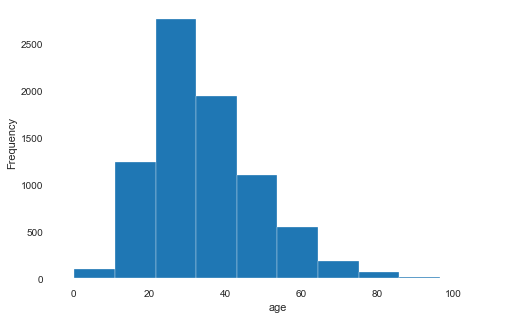

In [96]:
fatal_encounters_clean.age.plot.hist(figsize=(8, 5)).set_xlabel("age");

**Hypothesis** check: "the `age` column is right-skewed"

In [97]:
from scipy import stats

stat, p = stats.skewtest(fatal_encounters_clean.age, nan_policy="omit")

age_schema = Column(
    pa.Float,
    name="age",
    checks=Hypothesis(
        test=stats.skewtest,
        # positive stat means distribution is right-skewed
        # null hypothesis: distribution is drawn from a gaussian
        relationship=lambda stat, p: stat > 0 and p < 0.01
    ),
    nullable=True,
)

age_schema(fatal_encounters_clean);

What's the race distribution in the dataset?

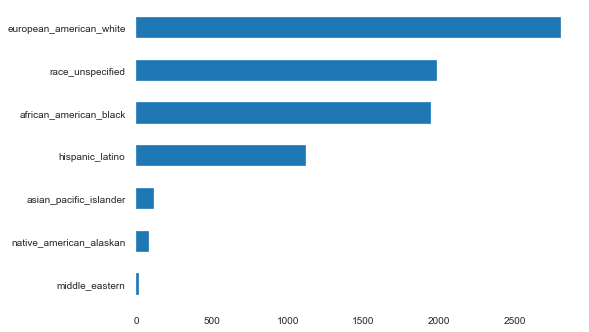

In [98]:
fatal_encounters_clean.race.value_counts().sort_values().plot.barh();

**Check**: "The top 3 most common races are `european-american/white`,
`african-american/black`, and `hispanic/latino` in that order"

In [99]:
most_common_races = [
    "european_american_white",
    "african_american_black",
    "hispanic_latino",
]

race_schema = Column(
    pa.String,
    name="race",
    checks=Check(
        lambda race: (
            race.mask(race == "race_unspecified")
            .dropna().value_counts()
            .sort_values(ascending=False)
            .head(len(most_common_races))
            .index.tolist() == most_common_races
        )
    ),
    nullable=True,
)

race_schema(fatal_encounters_clean);

Is there an association between `symptoms_of_mental_illness` and `cause_of_death`?

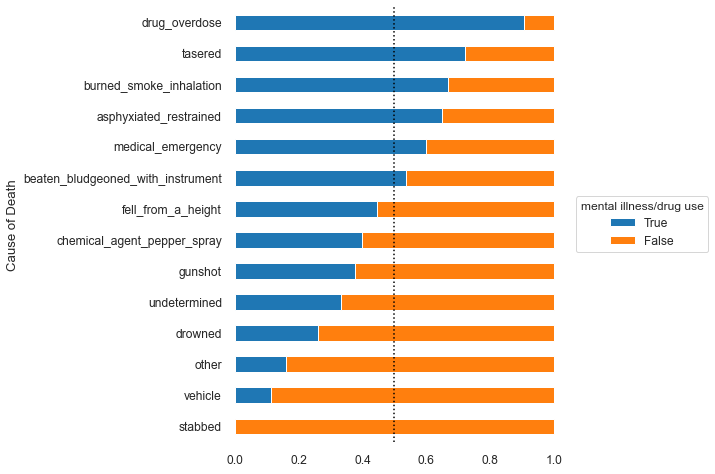

In [100]:
with sns.plotting_context(context="notebook", font_scale=1.1):
    ax = (
        fatal_encounters_clean
        .assign(
            cause_of_death=lambda x: (
                x.cause_of_death
                .mask(lambda x: x == "unknown")
            )
        )
        .groupby("cause_of_death")
        .symptoms_of_mental_illness
        .apply(lambda x: x.value_counts().pipe(lambda s: s / s.sum()))
        .unstack(1)
        .sort_index(axis="index")
        .sort_index(axis="columns", ascending=False)
        .fillna(0)
        .sort_values(True)
        .plot.barh(figsize=(6, 8), stacked=True)
    )
    ax.set_ylabel("Cause of Death")
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="mental illness/drug use")
    ax.axvline(0.5, color="k", linewidth=1.5, linestyle=":")
    sns.despine(bottom=True, left=True)

**Validation Rule**: "the proportion of people who died of certain
causes like drug overdose, being tasered, and falling from a height
have a greater than random chance of showing symptoms of mental illness."

**Deterministic Check**

For each discrete value in `cause_of_death`, compute the proportion where
`symptoms_of_mental_illness` is `True` and assert that it's greater than 50%

In [101]:
causes_of_death_assoc_with_mental_illness = [
    "drug_overdose", "tasered", "burned_smoke_inhalation",
    "asphyxiated_restrained",  "medical_emergency",
    "beaten_bludgeoned_with_instrument",
]

def check_gt_random_mental_illness(groups):
    # for each cause_of_death group, check if proportion
    # of sample with mental illness if greater than 50%
    return pd.Series({
        group: mental_illness.mean() > 0.5
        for group, mental_illness in groups.items()
    })

# you can use a Column object by itself
deterministic_mental_illness_schema = Column(
    pa.Bool,
    name="symptoms_of_mental_illness",
    checks=Check(
        check_gt_random_mental_illness,
        groupby="cause_of_death",
        groups=causes_of_death_assoc_with_mental_illness,
    )
)
deterministic_mental_illness_schema(fatal_encounters_clean);

**Probabilistic Check**

For each discrete value in `cause_of_death`, compute the proportion where
`symptoms_of_mental_illness` is `True` and assert that it's greater than 50%
using the `proportions_ztest` with an `alpha` value of `0.01`.

In [102]:
from statsmodels.stats.proportion import proportions_ztest

def hypothesis_gt_random_mental_illness(sample):
    return proportions_ztest(
        count=sample.sum(), nobs=sample.shape[0],
        value=0.5, alternative="larger",
    )

probabilistic_mental_illness_schema = Column(
    pa.Bool,
    name="symptoms_of_mental_illness",
    checks=[
        Hypothesis(
            hypothesis_gt_random_mental_illness,
            groupby="cause_of_death",
            samples=cause_of_death,
            relationship=lambda stat, p: p < 0.01,
            error=f"failed > random test: '{cause_of_death}'",
            raise_warning=True,  # <- raise a warning instead of an exception
        )
        for cause_of_death in causes_of_death_assoc_with_mental_illness
    ]
)
with warnings.catch_warnings():
    warnings.simplefilter("always")
    probabilistic_mental_illness_schema(fatal_encounters_clean);

/usr/local/miniconda3/envs/pandera-presentations/lib/python3.7/site-packages/pandera/schemas.py:1053: UserWarning: <Schema Column: 'symptoms_of_mental_illness' type=bool> failed series validator 2:
<Check _hypothesis_check: failed > random test: 'burned_smoke_inhalation'>
  warnings.warn(error_msg, UserWarning)
/usr/local/miniconda3/envs/pandera-presentations/lib/python3.7/site-packages/pandera/schemas.py:1053: UserWarning: <Schema Column: 'symptoms_of_mental_illness' type=bool> failed series validator 4:
<Check _hypothesis_check: failed > random test: 'medical_emergency'>
  warnings.warn(error_msg, UserWarning)
/usr/local/miniconda3/envs/pandera-presentations/lib/python3.7/site-packages/pandera/schemas.py:1053: UserWarning: <Schema Column: 'symptoms_of_mental_illness' type=bool> failed series validator 5:
<Check _hypothesis_check: failed > random test: 'beaten_bludgeoned_with_instrument'>
  warnings.warn(error_msg, UserWarning)


### Prepare Training and Test Sets

For functions that have tuple/list-like output, specify an integer
index `pa.check_output(schema, <int>)` to apply the schema to a
specific element in the output.

In [103]:
from sklearn.model_selection import train_test_split

target_schema = pa.SeriesSchema(
    pa.Bool,
    name="disposition_accidental",
    checks=Hypothesis.one_sample_ttest(
        popmean=0.0275, relationship="equal", alpha=0.01
    )
)
feature_schema = training_data_schema.remove_columns([target_schema.name])


@pa.check_input(training_data_schema)
@pa.check_output(feature_schema, 0)
@pa.check_output(feature_schema, 1)
@pa.check_output(target_schema, 2)
@pa.check_output(target_schema, 3)
def split_training_data(fatal_encounters_clean):
    return train_test_split(
        fatal_encounters_clean[list(feature_schema.columns)],
        fatal_encounters_clean[target_schema.name],
        test_size=0.2,
        random_state=45,
    )

X_train, X_test, y_train, y_test = split_training_data(fatal_encounters_clean)

### Model the Data

Import the tools

In [104]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#### `DataFrameSchema -> ColumnTransformer` 🤯

Create a transformer to numericalize the features using a `schema` object.
`Check`s have a `statistics` attribute that enables access to the properties
defined in the `schema`.

In [105]:
def column_transformer_from_schema(feature_schema):

    def transformer_from_column(column):
        column_schema = feature_schema.columns[column]
        if column_schema.pandas_dtype is pa.String:
            return make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(categories=[get_categories(column_schema)])
            )
        if column_schema.pandas_dtype is pa.Bool:
            return SimpleImputer(strategy="median")

        # otherwise assume numeric variable
        return make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler()
        )
    
    return ColumnTransformer([
        (column, transformer_from_column(column), [column])
        for column in feature_schema.columns
    ])

def get_categories(column_schema):
    for check in column_schema.checks:
        if check.name == "isin":
            return check.statistics["allowed_values"]
    raise ValueError("could not find Check.isin")

In [106]:
from sklearn import set_config

set_config(display='diagram')

### Define the transformer

In [107]:
transformer = column_transformer_from_schema(feature_schema)

In [108]:
transformer

ColumnTransformer(transformers=[('age',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age']),
                                ('gender',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categories=[['female',
                                                                             'male',
                                                                             'transgender',
                                                                             'transexual']]))]),
                                 ['gender']),
                                ('race',...
                                                                             'beaten_bludgeoned_with_instrument',
                                                                             'burned_smoke_inhalation',
                                                                             'chemical_agent_pepper_spray',
                                                                             'drowned',
                                                                             'drug_overdose',
                                                                             'fell_from_a_height',
                                                                             'gunshot',
                                                                             'medical_emergency',
                                                                             'other',
                                                                             'stabbed',
                                                                             'tasered',
                                                                             'undetermined',
                                                                             'unknown',
                                                                             'vehicle']]))]),
                                 ['cause_of_death']),
                                ('symptoms_of_mental_illness',
                                 SimpleImputer(strategy='median'),
                                 ['symptoms_of_mental_illness'])])

### Define and fit the modeling pipeline

You can even decorate object methods, specifying the argument name that
you want to apply a schema to.

In [109]:
pipeline = Pipeline([
    ("transformer", transformer),
    (
        "estimator",
        RandomForestClassifier(
            class_weight="balanced_subsample",
            n_estimators=500,
            min_samples_leaf=20,
            min_samples_split=10,
            max_depth=10,
            random_state=100,
        )
    )
])

fit_fn = pa.check_input(feature_schema, "X")(pipeline.fit)
fit_fn = pa.check_input(target_schema, "y")(fit_fn)
fit_fn(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('gender',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(categories=[['female',
                                                                                              'male',
                                                                                              'transgender',
                                                                                              'transex...
                                                                                              'medical_emergency',
                                                                                              'other',
                                                                                              'stabbed',
                                                                                              'tasered',
                                                                                              'undetermined',
                                                                                              'unknown',
                                                                                              'vehicle']]))]),
                                                  ['cause_of_death']),
                                                 ('symptoms_of_mental_illness',
                                                  SimpleImputer(strategy='median'),
                                                  ['symptoms_of_mental_illness'])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_leaf=20,
                                        min_samples_split=10, n_estimators=500,
                                        random_state=100))])

### Evaluate the Model

Use the `check_input` and `check_output` decorators to validate
the `estimator.predict_proba` method.

In [110]:
from sklearn.metrics import roc_auc_score, roc_curve

pred_schema = pa.SeriesSchema(pa.Float, Check.in_range(0, 1))

# check that the feature array input to predict_proba method adheres to the feature_schema
predict_fn = pa.check_input(feature_schema)(pipeline.predict_proba)

# check that the prediction array output is a probability.
predict_fn = pa.check_output(pred_schema, lambda x: pd.Series(x))(predict_fn)

yhat_train = pipeline.predict_proba(X_train)[:, 1]
print(f"train ROC AUC: {roc_auc_score(y_train, yhat_train):0.04f}")

yhat_test = pipeline.predict_proba(X_test)[:, 1]
print(f"test ROC AUC: {roc_auc_score(y_test, yhat_test):0.04f}")

train ROC AUC: 0.9207
test ROC AUC: 0.8479


Plot the ROC curves using an in-line `schema`.

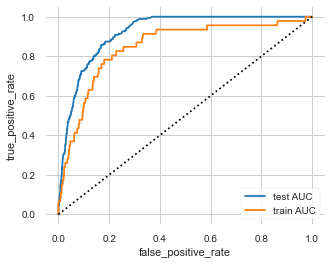

In [111]:
def plot_roc_auc(y_true, y_pred, label, ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_curve_df = pd.DataFrame({"fpr": fpr, "tpr": tpr}).pipe(
        pa.DataFrameSchema({
            "fpr": Column(pa.Float, Check.in_range(0, 1)),
            "tpr": Column(pa.Float, Check.in_range(0, 1)),
        })
    )
    return roc_curve_df.plot.line(x="fpr", y="tpr", label=label, ax=ax)

with sns.axes_style("whitegrid"):
    _, ax = plt.subplots(figsize=(5, 4))
    plot_roc_auc(y_train, yhat_train, "test AUC", ax)
    plot_roc_auc(y_test, yhat_test, "train AUC", ax)
    ax.set_ylabel("true_positive_rate")
    ax.set_xlabel("false_positive_rate")
    ax.plot([0, 1], [0, 1], color="k", linestyle=":")

### Audit the Model

`shap` package: https://github.com/slundberg/shap

In [112]:
import itertools

def feature_names_from_schema(column, schema):
    if schema.columns[column].pandas_dtype is pa.String:
        return [
            f"{column}_{x}" for x in get_categories(schema.columns[column])
        ]

    # otherwise assume numeric feature
    return [column]


feature_names = list(
    itertools.chain.from_iterable(
        feature_names_from_schema(column, feature_schema)
        for column in feature_schema.columns
    )
)

Create an `explainer` object. Here we want to check the inputs to the `transformer.transform` method.

In [113]:
import shap

explainer = shap.TreeExplainer(
    pipeline.named_steps["estimator"],
    feature_perturbation="tree_path_dependent",
)

transform_fn = pa.check_input(feature_schema)(
    pipeline.named_steps["transformer"].transform
)

X_test_array = transform_fn(X_test).toarray()

shap_values = explainer.shap_values(X_test_array, check_additivity=False)

### What factors are most predictive of the court ruling a case as "Accidental"?

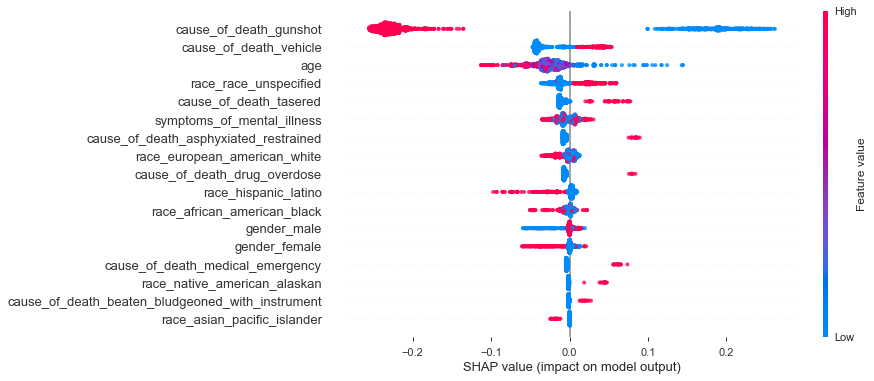

In [114]:
shap.summary_plot(
    shap_values[1],
    X_test_array,
    feature_names,
    plot_type="dot",
    max_display=17,
    plot_size=(10, 6),
    alpha=0.8,
)

The probability of the case being ruled as `accidental` ⬆️ if the `cause_of_death` is `vehicle,` `tasered`, `asphyxiated_restrained`, `medical_emergency`, or `drug_overdose`, or `race` is `race_unspecified` or `native_american_alaskan`.

The probability of the case being ruled as `accidental` ⬇️ if the `cause_of_death` is `gunshot` or `race` is `european_american_white`, or `asian_pacific_islander`.

### Write the Model Audit Schema

Create a dataframe with `{variable}` and `{variable}_shap` as columns

In [115]:
audit_dataframe = (
    pd.concat(
        [
            pd.DataFrame(X_test_array, columns=feature_names),
            pd.DataFrame(shap_values[1], columns=[f"{x}_shap" for x in feature_names])
        ],
        axis="columns"
    ).sort_index(axis="columns")
)

audit_dataframe.head(3)

,age,age_shap,cause_of_death_asphyxiated_restrained,cause_of_death_asphyxiated_restrained_shap,cause_of_death_beaten_bludgeoned_with_instrument,cause_of_death_beaten_bludgeoned_with_instrument_shap,cause_of_death_burned_smoke_inhalation,cause_of_death_burned_smoke_inhalation_shap,cause_of_death_chemical_agent_pepper_spray,cause_of_death_chemical_agent_pepper_spray_shap,...,race_hispanic_latino,race_hispanic_latino_shap,race_middle_eastern,race_middle_eastern_shap,race_native_american_alaskan,race_native_american_alaskan_shap,race_race_unspecified,race_race_unspecified_shap,symptoms_of_mental_illness,symptoms_of_mental_illness_shap
0,-0.534156,-0.039886,0.0,-0.007479,0.0,-0.001080,0.0,0.0,0.0,0.0,...,0.0,0.003194,0.0,0.0,0.0,-0.001401,1.0,0.030105,0.0,-0.007136
1,-0.820163,-0.012115,0.0,-0.008413,0.0,-0.001327,0.0,0.0,0.0,0.0,...,0.0,-0.002723,0.0,0.0,0.0,-0.001538,0.0,-0.012061,1.0,-0.011863
2,-0.319651,-0.037459,0.0,-0.008016,0.0,-0.001250,0.0,0.0,0.0,0.0,...,0.0,0.002469,0.0,0.0,0.0,-0.001629,0.0,-0.014678,0.0,-0.009156


Define two sample t-test that tests the relative impact of a
variable on the output probability of the model

In [116]:
def hypothesis_accident_probability(feature, increases=True):
    relationship = "greater_than" if increases else "less_than"
    return {
        feature: Column(checks=Check.isin([1, 0])),
        f"{feature}_shap": Column(
            pa.Float,
            checks=Hypothesis.two_sample_ttest(
                sample1=1,
                sample2=0,
                groupby=feature,
                relationship=relationship,
                alpha=0.01,
            )
        ),
    }

Programmatically construct the schema and validate `feature_shap_df`.

In [117]:
columns = {}
# increases probability of disposition "accidental"
for column in [
    "cause_of_death_vehicle",
    "cause_of_death_tasered",
    "cause_of_death_asphyxiated_restrained",
    "cause_of_death_medical_emergency",
    "cause_of_death_drug_overdose",
    "race_race_unspecified",
    "race_native_american_alaskan",
]:
    columns.update(hypothesis_accident_probability(column, increases=True))
    
# decreases probability of disposition "accidental"
for column in [
    "cause_of_death_gunshot",
    "race_european_american_white",
    "race_asian_pacific_islander",
]:
    columns.update(hypothesis_accident_probability(column, increases=False))

model_audit_schema = pa.DataFrameSchema(columns)

try:
    model_audit_schema(audit_dataframe)
    print("Model audit results pass! ✅")
except pa.errors.SchemaError as exc:
    print("Model audit results fail ❌")
    print(exc)

Model audit results pass! ✅


### More Questions 🤔

- Why would `race_unspecified` be associated with a higher probability of `accidental` rulings?
- Can we predict/impute the `disposition` of unreported, unknown, or pending cases? What would that get us?
- What's the generative process by which these data are being created and collected?
- Are the interaction effects between different demographic variables, e.g. `race_african_american_black` and other variables?

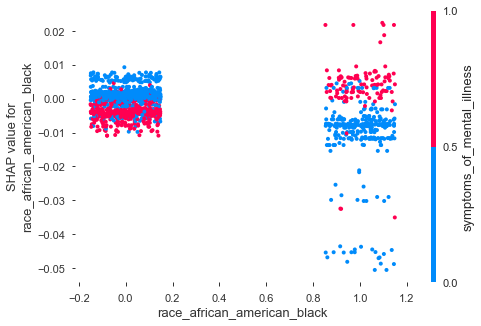

In [118]:
shap.dependence_plot(
    "race_african_american_black",
    shap_values[1],
    X_test_array,
    feature_names=feature_names,
    x_jitter=0.3,
)

# Takeaways

- Data validation is a means to multiple ends: _reproducibility_, _readability_, _maintainability_, and _statistical type safety_

- It's an iterative process between exploring the data, acquiring domain knowledge, and writing validation code.

- `pandera` schemas are executable contracts that enforce the statistical properties of a dataframe
  at runtime and can be flexibly interleaved with data processing and analysis logic.

- `pandera` doesn't automate data exploration or the data validation process. The user is responsible for identifying which parts of the pipeline are critical to test and defining the contracts under which data are considered valid.

# Experimental Features

**Schema Inference**

```python
schema = pa.infer_schema(dataframe)
```

**Schema Serialization**

```python
pa.io.to_yaml(schema, "schema.yml")
pa.io.to_script(schema, "schema.py")
```

# Roadmap: Feature Proposals

**Define domain-specific schemas, types, and checks, e.g. for machine learning**

```python
# validate a regression model dataset
schema = pa.machine_learning.supervised.TabularSchema(
    targets={"regression": pa.TargetColumn(type=pa.ml_dtypes.Continuous)},
    features={
        "continuous": pa.FeatureColumn(type=pa.ml_dtypes.Continuous),
        "categorical": pa.FeatureColumn(type=pa.ml_dtypes.Categorical),
        "ordinal": pa.FeatureColumn(type=pa.ml_dtypes.Ordinal),
    }
)
```

**Generate synthetic data based on schema definition as constraints**

```python
dataset = schema.generate_samples(100)
X, y = dataset[schema.features], dataset[schema.targets]
estimator.fit(X, y)
```

# Contributions are Welcome!

**Repo:** https://github.com/pandera-dev/pandera

1. Improving documentation
1. Submit feature requests (e.g. additional built-in `Check` and `Hypothesis` methods)
1. Submit bugs/issues or pull requests on Github

# Thank you!

[@cosmicBboy](https://twitter.com/cosmicBboy)